In [98]:
import math
import numpy as np
import h5py
import matplotlib.pyplot as plt
import scipy
from PIL import Image
from scipy import ndimage
import tensorflow as tf
from tensorflow.python.framework import ops
from cnn_utils import *
from sklearn.decomposition import PCA

%matplotlib inline
np.random.seed(1)

## 1. Load Data

In [99]:
data = np.load("Data.npy")
label = np.load("Label.npy")
# time = np.load("Time.npy")
print(data.shape)
print(label.shape)
def split_reshape_dataset(X, Y, ratio):
    X = X.T[:,:,np.newaxis, np.newaxis]
    Y = Y.T
    m = X.shape[0] # number of samples
    sortInd = np.arange(m)
    np.random.shuffle(sortInd)
    nTrain = int(ratio * m)
    X_train = X[sortInd[:nTrain], :, :, :]
    Y_train = Y[:, sortInd[:nTrain]]
    X_test = X[sortInd[nTrain:], :, :, :]
    Y_test = Y[:, sortInd[nTrain:]]
    return X_train, X_test, Y_train, Y_test

RatioTraining=0.95; # 0.8 before
X_train, X_test, Y_train, Y_test = split_reshape_dataset(data, label, RatioTraining)
Y_train =convert_to_one_hot(Y_train,2).T
Y_test = convert_to_one_hot(Y_test,2).T

print(X_train.shape)
print(Y_train.shape)
print(X_test.shape)
print(Y_test.shape)

(1024, 1366)
(1366, 1)
(1092, 1024, 1, 1)
(1092, 2)
(274, 1024, 1, 1)
(274, 2)


## 2. TensorFlow Functions

In [107]:
def create_placeholders(n_H0, n_W0, n_C0, n_y):
    """
    Creates the placeholders for the tensorflow session.
    
    Arguments:
    n_H0 -- scalar, height of an input image
    n_W0 -- scalar, width of an input image
    n_C0 -- scalar, number of channels of the input
    n_y -- scalar, number of classes
        
    Returns:
    X -- placeholder for the data input, of shape [None, n_H0, n_W0, n_C0] and dtype "float"
    Y -- placeholder for the input labels, of shape [None, n_y] and dtype "float"
    """

    ### START CODE HERE ### (≈2 lines)
    X = tf.placeholder(tf.float32,shape=(None, n_H0, n_W0, n_C0))#None
    Y = tf.placeholder(tf.float32,shape=(None,n_y))#None
    ### END CODE HERE ###
    
    return X, Y

def initialize_parameters():
    """
    Initializes weight parameters to build a neural network with tensorflow. The shapes are:
                        W1 : [4, 4, 3, 8]
                        W2 : [2, 2, 8, 16]
    Returns:
    parameters -- a dictionary of tensors containing W1, W2
    """
    
    tf.set_random_seed(1)                              # so that your "random" numbers match ours
    filtersize1=64; # originally 4
    filtersize2=32; # originally 2
    NumFilters1=32; #8
    NumFilters2=64; #16
    
        
    ### START CODE HERE ### (approx. 2 lines of code)
    W1 = tf.get_variable("W1", [filtersize1, 1, 1, NumFilters1], initializer = tf.contrib.layers.xavier_initializer(seed = 0))#None
    W2 = tf.get_variable("W2", [filtersize2, 1, NumFilters1, NumFilters2], initializer = tf.contrib.layers.xavier_initializer(seed = 0))#None
    ### END CODE HERE ###

    parameters = {"W1": W1,
                  "W2": W2}
    
    return parameters

def forward_propagation(X, parameters):
    """
    Implements the forward propagation for the model:
    CONV2D -> RELU -> MAXPOOL -> CONV2D -> RELU -> MAXPOOL -> FLATTEN -> FULLYCONNECTED
    
    Arguments:
    X -- input dataset placeholder, of shape (input size, number of examples)
    parameters -- python dictionary containing your parameters "W1", "W2"
                  the shapes are given in initialize_parameters

    Returns:
    Z3 -- the output of the last LINEAR unit
    """
    
    # Retrieve the parameters from the dictionary "parameters" 
    W1 = parameters['W1']
    W2 = parameters['W2']
    
    ### START CODE HERE ###
    # CONV2D: stride of 1, padding 'SAME'
    Z1 = tf.nn.conv2d(X,W1, strides = [1,1,1,1], padding = 'SAME')#None
    # RELU
    A1 = tf.nn.relu(Z1)#None
    # MAXPOOL: window 8x8, sride 8, padding 'SAME'
    P1 = tf.nn.max_pool(A1, ksize = [1,8,1,1], strides = [1,8,1,1], padding = 'SAME')#None
    # CONV2D: filters W2, stride 1, padding 'SAME'
    Z2 = tf.nn.conv2d(P1,W2, strides = [1,1,1,1], padding = 'SAME')#None
    # RELU
    A2 = tf.nn.relu(Z2)
    # MAXPOOL: window 4x4, stride 4, padding 'SAME'
    P2 = tf.nn.max_pool(A2, ksize = [1,4,1,1], strides = [1,4,1,1], padding = 'SAME')#None
    # FLATTEN
    P2 = tf.contrib.layers.flatten(P2)#None
    # FULLY-CONNECTED without non-linear activation function (not not call softmax).
    # 6 neurons in output layer. Hint: one of the arguments should be "activation_fn=None" 
    Z3 = tf.contrib.layers.fully_connected(P2, num_outputs=2,activation_fn=None)
    ### END CODE HERE ###

    return Z3

def compute_cost(Z3, Y):
    """
    Computes the cost
    
    Arguments:
    Z3 -- output of forward propagation (output of the last LINEAR unit), of shape (6, number of examples)
    Y -- "true" labels vector placeholder, same shape as Z3
    
    Returns:
    cost - Tensor of the cost function
    """
    
    ### START CODE HERE ### (1 line of code)
    cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits = Z3, labels = Y))
    ### END CODE HERE ###
    
    return cost

In [105]:
def model(X_train, Y_train, X_test, Y_test, learning_rate = 0.009,
          num_epochs = 100, minibatch_size = 10, print_cost = True):
    """
    Implements a three-layer ConvNet in Tensorflow:
    CONV2D -> RELU -> MAXPOOL -> CONV2D -> RELU -> MAXPOOL -> FLATTEN -> FULLYCONNECTED
    
    Arguments:
    X_train -- training set, of shape (None, 64, 64, 3)
    Y_train -- test set, of shape (None, n_y = 6)
    X_test -- training set, of shape (None, 64, 64, 3)
    Y_test -- test set, of shape (None, n_y = 6)
    learning_rate -- learning rate of the optimization
    num_epochs -- number of epochs of the optimization loop
    minibatch_size -- size of a minibatch
    print_cost -- True to print the cost every 100 epochs
    
    Returns:
    train_accuracy -- real number, accuracy on the train set (X_train)
    test_accuracy -- real number, testing accuracy on the test set (X_test)
    parameters -- parameters learnt by the model. They can then be used to predict.
    """
    
    ops.reset_default_graph()                         # to be able to rerun the model without overwriting tf variables
    tf.set_random_seed(1)                             # to keep results consistent (tensorflow seed)
    seed = 3                                          # to keep results consistent (numpy seed)
    (m, n_H0, n_W0, n_C0) = X_train.shape             
    n_y = Y_train.shape[1]                            
    costs = []                                        # To keep track of the cost
    
    # Create Placeholders of the correct shape
    ### START CODE HERE ### (1 line)
    X, Y = create_placeholders(n_H0, n_W0, n_C0, n_y)#None
    ### END CODE HERE ###

    # Initialize parameters
    ### START CODE HERE ### (1 line)
    parameters = initialize_parameters()#None
    ### END CODE HERE ###
    
    # Forward propagation: Build the forward propagation in the tensorflow graph
    ### START CODE HERE ### (1 line)
    Z3 = forward_propagation(X, parameters)#None
    ### END CODE HERE ###
    
    # Cost function: Add cost function to tensorflow graph
    ### START CODE HERE ### (1 line)
    cost = compute_cost(Z3, Y)#None
    ### END CODE HERE ###
    
    # Backpropagation: Define the tensorflow optimizer. Use an AdamOptimizer that minimizes the cost.
    ### START CODE HERE ### (1 line)
    optimizer = tf.train.AdamOptimizer(learning_rate = learning_rate).minimize(cost)#None
    ### END CODE HERE ###
    
    # Initialize all the variables globally
    init = tf.global_variables_initializer()
     
    # Start the session to compute the tensorflow graph
    with tf.Session() as sess:
        
        # Run the initialization
        sess.run(init)
        
        # Do the training loop
        for epoch in range(num_epochs):

            minibatch_cost = 0.
            num_minibatches = int(m / minibatch_size) # number of minibatches of size minibatch_size in the train set
            seed = seed + 1
            #print(Y_train.shape)
            minibatches = random_mini_batches(X_train, Y_train, minibatch_size, seed)

            for minibatch in minibatches:

                # Select a minibatch
                (minibatch_X, minibatch_Y) = minibatch
                # IMPORTANT: The line that runs the graph on a minibatch.
                # Run the session to execute the optimizer and the cost, the feedict should contain a minibatch for (X,Y).
                ### START CODE HERE ### (1 line)
                _ , temp_cost = sess.run([optimizer, cost], feed_dict={X: minibatch_X, Y: minibatch_Y})#None
                ### END CODE HERE ###
                
                minibatch_cost += temp_cost / num_minibatches
                

            # Print the cost every epoch
            if print_cost == True and epoch % 5 == 0:
                print ("Cost after epoch %i: %f" % (epoch, minibatch_cost))
            if print_cost == True and epoch % 1 == 0:
                costs.append(minibatch_cost)
        
        
        # plot the cost
        plt.plot(np.squeeze(costs))
        plt.ylabel('cost')
        plt.xlabel('iterations (per tens)')
        plt.title("Learning rate =" + str(learning_rate))
        plt.show()

        # Calculate the correct predictions
        predict_op = tf.argmax(Z3, 1)
        correct_prediction = tf.equal(predict_op, tf.argmax(Y, 1))
        
        # Calculate accuracy on the test set
        accuracy = tf.reduce_mean(tf.cast(correct_prediction, "float"))
        print(accuracy)
        train_accuracy = accuracy.eval({X: X_train, Y: Y_train})
        test_accuracy = accuracy.eval({X: X_test, Y: Y_test})
        print("Train Accuracy:", train_accuracy)
        print("Test Accuracy:", test_accuracy)
                
        return train_accuracy, test_accuracy, parameters

Cost after epoch 0: 6797.664230
Cost after epoch 5: 0.836051
Cost after epoch 10: 0.672751
Cost after epoch 15: 0.673444
Cost after epoch 20: 0.672708
Cost after epoch 25: 0.672939
Cost after epoch 30: 0.672938
Cost after epoch 35: 0.672800
Cost after epoch 40: 0.698355
Cost after epoch 45: 0.699651
Cost after epoch 50: 0.697501
Cost after epoch 55: 0.698406
Cost after epoch 60: 0.697964
Cost after epoch 65: 0.698003
Cost after epoch 70: 0.698392
Cost after epoch 75: 0.698250
Cost after epoch 80: 0.698987
Cost after epoch 85: 0.698148
Cost after epoch 90: 0.698559
Cost after epoch 95: 0.698015


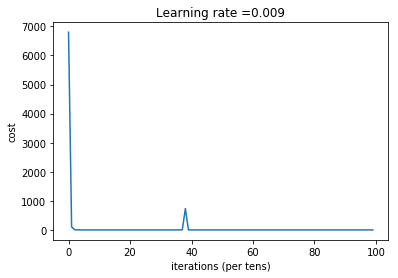

Tensor("Mean_1:0", shape=(), dtype=float32)
Train Accuracy: 0.510989
Test Accuracy: 0.5109489


In [108]:
_, _, parameters = model(X_train, Y_train, X_test, Y_test)